In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report)

In [3]:
df=pd.read_csv("netflix_titles.csv")
df

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...
...,...,...,...,...,...,...,...,...,...,...,...,...
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a..."
8803,s8804,TV Show,Zombie Dumb,NaN,NaN,NaN,"July 1, 2019",2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g..."
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero..."


In [5]:
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

In [6]:
str_cols = df.select_dtypes(include=["object"]).columns.tolist()
for c in str_cols:
    df[c] = df[c].astype(str).str.strip().replace({"nan": pd.NA})
    df[c] = df[c].str.replace(r"\s+", " ", regex=True)

In [7]:
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')

In [8]:
def split_duration(x):
    if pd.isna(x):
        return pd.Series([pd.NA, pd.NA])
    parts = str(x).split()
    if len(parts) == 2 and parts[0].isdigit():
        return pd.Series([int(parts[0]), parts[1].lower()])
    import re
    m = re.search(r"(\d+)", str(x))
    unit = ' '.join([p for p in parts if not p.isdigit()]).lower() if len(parts)>1 else pd.NA
    return pd.Series([int(m.group(1)) if m else pd.NA, unit])

df[['duration_int', 'duration_type']] = df['duration'].apply(split_duration)

In [10]:
df['listed_in'] = df['listed_in'].astype("string").str.replace(r"\s*,\s*", ", ", regex=True)

In [11]:
for col in ['cast', 'director', 'country']:
    if col in df.columns:
        df[col] = df[col].replace({"nan": pd.NA})
        df[col] = df[col].fillna("Unknown")

In [12]:
df = df.drop_duplicates()

In [13]:
for c in df.select_dtypes(include=['object']).columns:
    df[c] = df[c].astype(str).str.strip().replace({'nan': pd.NA})
    df[c] = df[c].str.replace(r"\s+", " ", regex=True)

In [14]:
if 'date_added' in df.columns:
    df['year_added'] = pd.DatetimeIndex(df['date_added']).year
    df['month_added'] = pd.DatetimeIndex(df['date_added']).month
else:
    df['year_added'] = pd.NA
    df['month_added'] = pd.NA

In [15]:
if 'release_year' in df.columns:
    df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce').astype('Int64')
    df['content_age'] = df['year_added'] - df['release_year']
    df['content_age'] = df['content_age'].fillna(0)
    df['content_age'] = df['content_age'].apply(lambda x: x if (pd.notna(x) and x >= 0) else 0)
else:
    df['content_age'] = 0

In [16]:
if 'type' in df.columns:
    df['is_movie'] = df['type'].str.lower().map(lambda x: 1 if x == 'movie' else 0)
else:
    df['is_movie'] = 0

In [17]:
if 'listed_in' in df.columns:
    df['genres_list'] = df['listed_in'].fillna('').apply(lambda s: [g.strip() for g in s.split(',')] if s else [])

In [18]:
if 'rating' in df.columns:
    df['rating'] = df['rating'].fillna('Unknown')

In [19]:
print("\nBasic counts:")
print("Total titles:", len(df))
if 'type' in df.columns:
    print(df['type'].value_counts())


Basic counts:
Total titles: 8807
Movie      6131
TV Show    2676
Name: type, dtype: int64


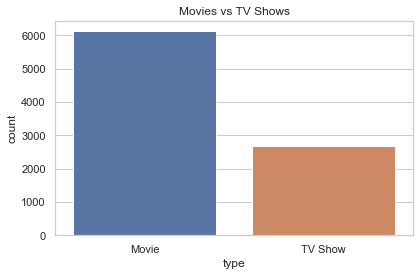

In [20]:
sns.set(style='whitegrid')

try:
    plt.figure(figsize=(6,4))
    if 'type' in df.columns:
        sns.countplot(data=df, x='type', order=df['type'].value_counts().index)
    plt.title("Movies vs TV Shows")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Plot error (type):", e)

In [21]:
if 'country' in df.columns:
    top_countries = df['country'].value_counts().head(10)
    print("\nTop countries:\n", top_countries)


Top countries:
 United States     2818
India              972
Unknown            831
United Kingdom     419
Japan              245
South Korea        199
Canada             181
Spain              145
France             124
Mexico             110
Name: country, dtype: int64


In [22]:
if 'genres_list' in df.columns:
    from collections import Counter
    genre_flat = [g for sub in df['genres_list'] for g in sub if g]
    top_genres = pd.Series(Counter(genre_flat)).sort_values(ascending=False).head(10)
    print("\nTop genres:\n", top_genres)


Top genres:
 International Movies        2752
Dramas                      2427
Comedies                    1674
International TV Shows      1351
Documentaries                869
Action & Adventure           859
TV Dramas                    763
Independent Movies           756
Children & Family Movies     641
Romantic Movies              616
dtype: int64


In [23]:
candidate_features = []
for c in ['duration_int','content_age','rating','country','year_added']:
    if c in df.columns:
        candidate_features.append(c)
print("\nCandidate features for supervised model:", candidate_features)

X = df[candidate_features].copy()
y = df['is_movie'].copy() 


Candidate features for supervised model: ['duration_int', 'content_age', 'rating', 'country', 'year_added']


In [24]:
X = X.copy()
initial_len = len(X)
X = X.dropna(subset=['duration_int'])
y = y.loc[X.index]
print("Rows after dropping missing duration_int for modeling:", len(X), "(dropped", initial_len - len(X), ")")

Rows after dropping missing duration_int for modeling: 8807 (dropped 0 )


In [25]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

Numeric features: ['content_age', 'year_added']
Categorical features: ['duration_int', 'rating', 'country']


In [26]:
numeric_transformer = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("Train / test sizes:", X_train.shape, X_test.shape)
print("No. of movies in train:", y_train.sum(), " / test:", y_test.sum())

Train / test sizes: (7045, 5) (1762, 5)
No. of movies in train: 4904  / test: 1227


In [29]:
pipe_lr = Pipeline([('preproc', preprocessor),
                    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))])

pipe_rf = Pipeline([('preproc', preprocessor),
                    ('clf', RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'))])

In [30]:
pipe_lr.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['content_age',
                                                   'year_added']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                    

In [31]:
y_pred_lr = pipe_lr.predict(X_test)
y_proba_lr = pipe_lr.predict_proba(X_test)[:, 1] if hasattr(pipe_lr.named_steps['clf'], "predict_proba") else np.zeros(len(y_test))

y_pred_rf = pipe_rf.predict(X_test)
y_proba_rf = pipe_rf.predict_proba(X_test)[:, 1] if hasattr(pipe_rf.named_steps['clf'], "predict_proba") else np.zeros(len(y_test))

In [32]:
def eval_model(name, y_true, y_pred, y_proba):
    print(f"\n=== {name} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, zero_division=0))
    print("Recall:", recall_score(y_true, y_pred, zero_division=0))
    print("F1:", f1_score(y_true, y_pred, zero_division=0))
    try:
        print("ROC AUC:", roc_auc_score(y_true, y_proba))
    except Exception:
        print("ROC AUC: not computable")
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification report:\n", classification_report(y_true, y_pred, zero_division=0))

eval_model("Logistic Regression", y_test, y_pred_lr, y_proba_lr)
eval_model("Random Forest", y_test, y_pred_rf, y_proba_rf)




=== Logistic Regression ===
Accuracy: 0.9982973893303064
Precision: 0.9975609756097561
Recall: 1.0
F1: 0.9987789987789988
ROC AUC: 0.9999954299293925
Confusion matrix:
 [[ 532    3]
 [   0 1227]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       535
           1       1.00      1.00      1.00      1227

    accuracy                           1.00      1762
   macro avg       1.00      1.00      1.00      1762
weighted avg       1.00      1.00      1.00      1762


=== Random Forest ===
Accuracy: 0.9960272417707151
Precision: 0.9943273905996759
Recall: 1.0
F1: 0.9971556277935799
ROC AUC: 0.9999474441880127
Confusion matrix:
 [[ 528    7]
 [   0 1227]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       535
           1       0.99      1.00      1.00      1227

    accuracy                           1.00      1762
   macro avg       

In [34]:
try:
    # use (release_year, duration_int, content_age) as join key if duplicates are many, this is approximate
    df_enh = df.copy()
    if 'cluster' in cluster_df.columns:
        # create a helper key on both
        cluster_df['_k'] = cluster_df['release_year'].astype(str) + "_" + cluster_df['duration_int'].astype(str) + "_" + cluster_df['content_age'].astype(str)
        df_enh['_k'] = df_enh['release_year'].astype(str) + "_" + df_enh['duration_int'].astype(str) + "_" + df_enh['content_age'].astype(str)
        df_enh = df_enh.merge(cluster_df[['_k','cluster']], on='_k', how='left')
        df_enh.drop(columns=['_k'], inplace=True)
    # add predicted labels (random forest) on rows used for modeling
    df_enh.loc[X_test.index, 'pred_is_movie_rf'] = y_pred_rf
    df_enh.to_csv(out_enh, index=False)
    print("Saved enhanced dataset to:", out_enh)
except Exception as e:
    print("Could not save enhanced dataset:", e)

print("\n=== SHORT SUMMARY ===")
print("Rows:", len(df))
print("Columns:", df.columns.tolist())
print("Features engineered: year_added, month_added, content_age, is_movie (binary)")
print("Saved cleaned and enhanced CSVs to /mnt/data")
print("Models trained: LogisticRegression, RandomForest (predicting Movie vs TV Show)")
print("Unsupervised: KMeans clustering (3 clusters) on release_year, duration_int, content_age")


Could not save enhanced dataset: name 'cluster_df' is not defined

=== SHORT SUMMARY ===
Rows: 8807
Columns: ['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description', 'duration_int', 'duration_type', 'year_added', 'month_added', 'content_age', 'is_movie', 'genres_list']
Features engineered: year_added, month_added, content_age, is_movie (binary)
Saved cleaned and enhanced CSVs to /mnt/data
Models trained: LogisticRegression, RandomForest (predicting Movie vs TV Show)
Unsupervised: KMeans clustering (3 clusters) on release_year, duration_int, content_age
